In [1]:
import numpy as np
import pandas as pd
import math
import random
import re

import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

# Import required for random matrix generation
import scipy.stats as stats
import scipy.sparse as sparse
from docplex.cp.utils_visu import display

from qiskit import *
from qiskit_optimization.applications import Maxcut, Tsp, GraphPartition

# QP specific imports
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.converters import QuadraticProgramToQubo, LinearInequalityToPenalty

# QAOA and circuit cutting specific imports
from qiskit.circuit.library import QAOAAnsatz
from circuit_knitting_toolbox.circuit_cutting.wire_cutting import cut_circuit_wires

/var/folders/64/rp2jr10901n6vdvhsbn1fz7c0000gn/T/ipykernel_4961/2018274210.py:25: DeprecationWarning: The package namespace circuit_knitting_toolbox is deprecated and will be removed no sooner than Circuit Knitting Toolbox 0.4.0. Use namespace circuit_knitting instead.
  from circuit_knitting_toolbox.circuit_cutting.wire_cutting import cut_circuit_wires
/var/folders/64/rp2jr10901n6vdvhsbn1fz7c0000gn/T/ipykernel_4961/2018274210.py:25: DeprecationWarning: The package namespace circuit_knitting_toolbox.circuit_cutting is deprecated and will be removed no sooner than Circuit Knitting Toolbox 0.4.0. Use namespace circuit_knitting.cutting instead.
  from circuit_knitting_toolbox.circuit_cutting.wire_cutting import cut_circuit_wires


In [2]:
import random
import seaborn as sns

# Import required for random matrix generation
import scipy.stats as stats
import scipy.sparse as sparse
from docplex.cp.utils_visu import display

from qiskit import *


# QAOA and circuit cutting specific imports
from qiskit.circuit.library import QAOAAnsatz
from circuit_knitting_toolbox.circuit_cutting.wire_cutting import cut_circuit_wires

In [3]:
# useful additional packages
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

from qiskit_aer import Aer
from qiskit.tools.visualization import plot_histogram
from qiskit.circuit.library import TwoLocal
from qiskit_optimization.applications import Maxcut, Tsp 
from qiskit.algorithms.minimum_eigensolvers import SamplingVQE, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import SPSA
from qiskit.utils import algorithm_globals
from qiskit.primitives import Sampler
from qiskit_optimization.algorithms import MinimumEigenOptimizer

In [4]:
import string
labels = string.ascii_uppercase + string.ascii_lowercase   #string.ascii_letters#
from collections import OrderedDict

from matplotlib import pylab as pl

from sklearn.cluster import SpectralClustering
from sklearn import metrics
import markov_clustering as mc

In [5]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [6]:
def sprandsym(n, density,seed):
    np.random.seed((seed))
    rvs = stats.poisson(25, loc=10).rvs
    X = sparse.random(n, n, density=density, data_rvs=rvs)
    upper_X = sparse.triu(X) 
    result = upper_X + upper_X.T - sparse.diags(X.diagonal())
    return result

def binarize_sparse_matrix(sparse_matrix):
    # create a copy of the sparse matrix to keep the operation non-destructive
    sparse_copy = sparse_matrix.copy()
    #sparse_copy=sparse_copy-sparse.diags(sparse_copy.diagonal())
    # find the coordinates of non-zero elements
    non_zero_coords = sparse_copy.nonzero()
    # set those elements to 1
    sparse_copy[non_zero_coords] = 1
    return sparse_copy

def generate_graph_from_matrix(binarized_sparse_mat):
    G = nx.from_scipy_sparse_array(binarized_sparse_mat)
    return G


# create the quadratic program instance and define the variables
def create_qp_from_qmatrix(Q_matrix):
    max_keys = Q_matrix.shape[0]
    qp = QuadraticProgram('QUBO Matrix Optimization')
    x = qp.binary_var_list(name='x', keys=range(1, max_keys + 1))

    linear_vars = {qp.get_variable(i).name: Q_matrix[i, j]
                   for i in range(max_keys) for j in range(max_keys) if i == j}
    quadratic_vars = {(qp.get_variable(i).name, qp.get_variable(j).name): Q_matrix[i, j]
                      for i in range(max_keys) for j in range(max_keys) if i != j}

    qp.minimize(linear=linear_vars, quadratic=quadratic_vars)
    return qp
    #print(self.qp.prettyprint())


def create_qaoa_ansatz(qp):
    #self.create_qp_from_qmatrix()
    h_qubo, offset = qp.to_ising()
    #print(h_qubo)
    qaoa_ansatz = QAOAAnsatz(cost_operator=h_qubo, reps=1, )
    qaoa_ansatz.entanglement = 'linear'
    params = len(qaoa_ansatz.parameters)
    theta_range = np.linspace(0, np.pi, params)
    qaoa_qc = qaoa_ansatz.bind_parameters(theta_range)
    decomposed_qaoa_ansatz = qaoa_qc.decompose().decompose().decompose().decompose()
    return h_qubo, offset, decomposed_qaoa_ansatz


In [7]:
def sc_partitioning(max_cluster_size, qsubgraph_prop):
    max_cluster_size = max_cluster_size # corresponds to the h/w qubit size
    part_lbl = {}
    max_key_cnt = -1
    for i, key in enumerate(qsubgraph_prop.keys()):  
        #print(f'Subgraph nodes : {key}')
        if len(key)>max_cluster_size:
            #print(f'large subgraph nodes : {key}')
            #print(len(key))
            sc_n_clusters = int(np.ceil(len(key)/max_cluster_size))
            #print(f'sc_n_clusters : {sc_n_clusters}')
            sc = SpectralClustering(sc_n_clusters, affinity='precomputed', n_init=100)
            subgraph_mat = qsubgraph_prop[key]
            sc.fit(subgraph_mat)
            sclbl = sc.labels_
            #print(f'Original sclbl : {sclbl}')

            #increment the sclbl with max_key_cnt so that the next sub-graphs labels are not repeated
            sclbl = sclbl + max_key_cnt +1
            for j, k_ in enumerate(key):
                part_lbl[k_] = labels[sclbl[j]] 

            max_key_cnt = np.max(sclbl) 
            
        else:
            max_key_cnt += 1
            for k in key:
                #
                part_lbl[k] = labels[max_key_cnt]
            #print(f'label for small graph : {labels[max_key_cnt]}')
    #print(part_lbl)

    return part_lbl



def mc_partitioning(max_cluster_size, qsubgraph_prop):
    max_cluster_size = max_cluster_size 
    part_lbl = {}
    max_key_cnt = -1
    for i, key in enumerate(qsubgraph_prop.keys()):  
        if len(key)>max_cluster_size:
            #print(f'large subgraph nodes : {key}')
            key_dict = {}
            for i, k in enumerate(key):
                key_dict[i] = k

            #print(len(key))
            subgraph_mat = qsubgraph_prop[key]
            result = mc.run_mcl(subgraph_mat, inflation=1.2)#TODO: best inflation value given the node count
            mclbl = mc.get_clusters(result)
            #print(f'Original mclbl : {mclbl}')

            #for each cluster in mc lbl
            for j, lbl in enumerate(mclbl):
                #print(f'mc lbl : {lbl}')

                #increment the mclbl with max_key_cnt so that the next sub-graphs labels are not repeated

                mclbl = j + max_key_cnt +1
                for k_ in lbl:
                    #print(f'labels : {labels[sclbl[j]]}')
                    part_lbl[key_dict[k_]] = labels[mclbl] 

                    #max_key_cnt = np.max(sclbl) 
                    #print(f'max key cnt : {max_key_cnt}')
                #print(f'labels for this subgraph: {labels[mclbl]}')
            max_key_cnt = mclbl
            #print(f'large mclbl : {mclbl}')
            #print(f'large max_key_cnt : {max_key_cnt}')
            #print(f'large part_lbl : {part_lbl}')

        else:
            #print(f'Subgraph nodes : {key}')
            max_key_cnt += 1
            #print(f'small max_key_cnt : {max_key_cnt}')
            for k in key:
                #
                part_lbl[k] = labels[max_key_cnt]
            #print(f'label for small graph : {labels[max_key_cnt]}')


    #print(part_lbl)

    mc_ordered_part_lbl = OrderedDict(sorted(part_lbl.items()))
    mc_ordered_part_lbl
    mc_partition_labels = ''.join(mc_ordered_part_lbl.values())
    print(f'\nPartition labels for CKT: {mc_partition_labels}')


def ckt_partition(qaoa_decomposed, partition_labels, observables):
    partitioned_problem = partition_problem(circuit=qaoa_decomposed, 
                                            partition_labels=partition_labels, 
                                            observables=observables)
    #subcircuits = partitioned_problem.subcircuits
    #subobservables = partitioned_problem.subobservables
    bases = partitioned_problem.bases
    sampling_overhead = np.prod([basis.overhead for basis in bases])
    print(f"Sampling overhead: {sampling_overhead}")
    return sampling_overhead



def ckt_sc_mc(mat_size, prob, random_seeds, max_cluster_sizes):
    
    cols = ['n', 'p', 'seed', 'max_cluster_size', 'M', 'qsubgraph_prop',
            'partition_labels','sampling_overhead', 'sampling_overhead/max_cluster' ,
           'sampling_overhead/p']
    
    df = pd.DataFrame(columns=cols)
    i = 0
    for n in mat_size:
        for p in (prob): 
            for seed in random_seeds:
                
                M=sprandsym(n,p,seed)
                M=binarize_sparse_matrix(M)
                q=generate_graph_from_matrix(M)
                qnum_sub_graphs, largest_subgraph_size, qsubgraph_prop, max_subgraph_nodes = get_subgraph_properties1(q)
                #print(max_subgraph_nodes)

                ## qaoa for original circuit
                qp = create_qp_from_qmatrix(M)
                qp2qubo = QuadraticProgramToQubo()
                qubo = qp2qubo.convert(qp)
                qubitOp, offset = qubo.to_ising()

                qaoa = QAOAAnsatz(cost_operator=qubitOp,reps=1)
                qaoa_decomposed = qaoa.decompose().decompose().decompose().decompose()

                qaoa_observable_pat = '[A-Z]+'
                observables = PauliList(re.findall(qaoa_observable_pat, str(qubitOp)))

                for max_cluster_size in max_cluster_sizes:
                    i += 1
                    #sc partition
                    part_lbl = sc_partitioning(max_cluster_size, qsubgraph_prop)
                    ordered_part_lbl = OrderedDict(sorted(part_lbl.items()))
                    ordered_part_lbl
                    partition_labels = ''.join(ordered_part_lbl.values())
                    print(f'\nPartition labels for CKT: {partition_labels}')
                    #sampling_overhead = np.prod([basis.overhead for basis in bases])
                    sampling_overhead = ckt_partition(qaoa_decomposed, partition_labels, observables)

                    df.loc[i,'n'] = n
                    df.loc[i,'p'] = p
                    df.loc[i,'seed'] = seed
                    df.loc[i,'max_cluster_size'] = max_cluster_size
                    #df['M'] = M
                    df.loc[i,'qsubgraph_prop'] = [qsubgraph_prop]
                    df.loc[i,'partition_labels'] = partition_labels
                    df.loc[i,'sampling_overhead'] = sampling_overhead
                    df.loc[i,'sampling_overhead/max_cluster'] = sampling_overhead/max_cluster_size
                    df.loc[i,'sampling_overhead/p'] = sampling_overhead/p
    return df
  
    
    


In [10]:
def get_subgraph_properties1(G):
    cnt=0
    subgraphs = (G.subgraph(c) for c in nx.connected_components(G))
    subgraph_prop = {}
    prop = []
    max_size = []
    max_subgraph_nodes = ''
    for s in subgraphs:
        #print(s.nodes())
        n = tuple(s.nodes())
        subgraph_prop[n] = nx.adjacency_matrix(s).todense()
        #print(s.size())
        #print(f'Subgraph {cnt}:: Num of Edges: {s.size()},  Nodes : {s.nodes()}  ')
        cnt+=1
        max_size.append(len(s.nodes()))
        if len(s.nodes)== np.max(max_size):
            max_subgraph_nodes = s.nodes()
        
        
    #print(max_subgraph_nodes)
    return cnt, np.max(max_size), subgraph_prop, max_subgraph_nodes



In [311]:
'''def draw_subgraph(subgraph, subgraph_labels, cluster_labels):
    colors = ['red', 'blue', 'green', 'yellow']
    color_map = []
    for node in subgraph:
        color_map.append(colors[cluster_labels[node]])
    plt.figure(figsize=(3,3))
    pos = nx.circular_layout(q1)
    nx.draw(q1, node_color=color_map, with_labels=True, labels=subgraph_labels,pos=pos )
    plt.show()
    
    
colors = ['red', 'blue', 'green', 'yellow']
color_map = []
for node in q1:
    color_map.append(colors[node_clr[node]])
plt.figure(figsize=(3,3))
pos = nx.circular_layout(q1)
nx.draw(q1, node_color=color_map, with_labels=True, labels=node_lbl,pos=pos )
plt.show()'''


def draw_subgraph(subgraph, subgraph_labels, cluster_labels):
    colors = ['red', 'blue', 'green', 'yellow']
    color_map = []
    for node in subgraph:
        color_map.append(colors[cluster_labels[node]]) #sorted(q1.nodes) if subgraph_labels are renamed
    plt.figure(figsize=(3,3))
    pos = nx.circular_layout(q1)
    nx.draw(q1, node_color=color_map, with_labels=True, pos=pos )#,labels=subgraph_labels )#- not required when nodelabels are renamed
    plt.show()-p`1

In [312]:
matrix_sizes =  [20] 
matrix_densities = [0.07]#,0.07,0.1,0.2,0.25,0.27] #[0.20,0.30,0.40,0.50,0.60,0.70]
num_of_experiments = 1
random_seeds = [random.randint(30, 100) for _ in range(num_of_experiments)]
max_cluster_sizes = [3]#,5,7]

n=matrix_sizes[0]
p=matrix_densities[0]
seed = [random.randint(30, 1000) for _ in range(num_of_experiments)][0]

max_cluster_size = 3

In [313]:
M=sprandsym(n,p,seed)
M=binarize_sparse_matrix(M)
q=generate_graph_from_matrix(M)
qnum_sub_graphs, largest_subgraph_size, qsubgraph_prop, max_subgraph_nodes = get_subgraph_properties1(q)


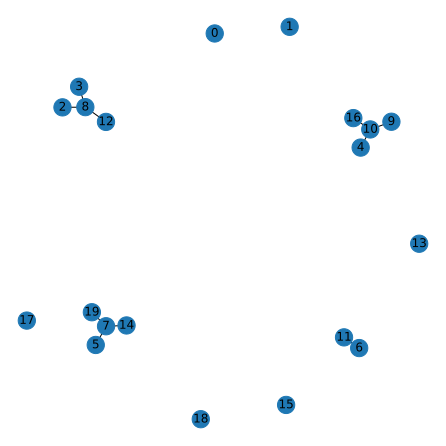

In [314]:
plt.figure(figsize=(6,6))
pos = nx.spring_layout(q, seed=31137946)
nx.draw(q,pos, with_labels=True )


In [321]:
max_subgraph_nodes

NodeView((19, 5, 14, 7))

In [322]:
data = qsubgraph_prop[tuple(max_subgraph_nodes)]

In [323]:
q1=nx.from_numpy_array(data)

In [319]:
nx.relabel_nodes(q1, node_lbl, copy=False)

In [373]:
node_lbl = dict(zip(list(sorted(q1.nodes)), list(max_subgraph_nodes)))

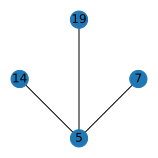

In [374]:
nx.set_node_attributes(q1, values=node_lbl, name='labels')
plt.figure(figsize=(2,2))
pos = nx.circular_layout(q1)
nx.draw(q1, with_labels=True, labels=node_lbl, pos=pos)

In [326]:
n_clusters = int(np.ceil(len(max_subgraph_nodes)/max_cluster_size))
n_clusters

2

In [327]:
data = np.array(data)

### kmeans

In [376]:
kmeans = KMeans(init="k-means++", n_clusters=n_clusters, n_init=4, random_state=0)
kmeans.fit(data)
kmeans_lbl = list(kmeans.labels_)
node_clr = dict(zip(list(sorted(q1.nodes)), kmeans_lbl))

In [377]:
kmeans_lbl

[0, 0, 0, 1]

In [378]:
node_lbl

{5: 19, 7: 5, 14: 14, 19: 7}

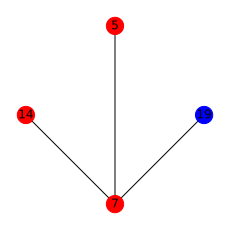

In [379]:
draw_subgraph(q1, node_lbl, node_clr )

#### k-means with PCA initialization

In [332]:
pca = PCA(n_components=n_clusters).fit(data)
kmeans_pca = KMeans(init=pca.components_, n_clusters=n_clusters, n_init=1)
kmeans_pca.fit(data)

KMeans(init=array([[ 0.5       ,  0.5       ,  0.5       , -0.5       ],
       [ 0.8660254 , -0.28867513, -0.28867513,  0.28867513]]),
       n_clusters=2, n_init=1)

In [382]:
kmeans_pca.labels_
node_clr_pca = dict(zip(list(sorted(q1.nodes)), kmeans_pca.labels_))

In [383]:
draw_subgraph(q1, node_clr_pca, kmeans_pca.labels_ )

IndexError: index 19 is out of bounds for axis 0 with size 4

#### k-means with random initialization

In [335]:
kmeans_rand = KMeans(init="random", n_clusters=n_clusters, n_init=4, random_state=0)
kmeans_rand.fit(data)

KMeans(init='random', n_clusters=2, n_init=4, random_state=0)

In [336]:
kmeans_rand.labels_

array([0, 0, 0, 1], dtype=int32)

In [384]:
node_clr_kmeansrand = dict(zip(list(sorted(q1.nodes)), kmeans_rand.labels_))

In [385]:
draw_subgraph(q1, node_clr_kmeansrand, kmeans_rand.labels_ )

IndexError: index 19 is out of bounds for axis 0 with size 4

### Birch

In [339]:
from sklearn.cluster import Birch

In [340]:
brc = Birch(n_clusters=4)
brc.fit(data)
Birch(n_clusters=4)
brc.predict(data)

/Users/hema/opt/anaconda3/envs/CC/lib/python3.10/site-packages/sklearn/cluster/_birch.py:726: ConvergenceWarning: Number of subclusters found (2) by BIRCH is less than (4). Decrease the threshold.
  warnings.warn(


array([0, 0, 0, 1])

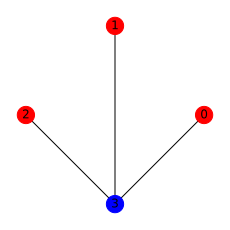

In [341]:
birch_labels = brc.predict(data)
node_clr_birch = dict(zip(list(q1.nodes), birch_labels))
draw_subgraph(q1, node_lbl, node_clr_birch )

### Agglomerative clustering

In [342]:
from sklearn.cluster import AgglomerativeClustering
clustering = AgglomerativeClustering(n_clusters=4).fit(data)
clustering.labels_

/Users/hema/opt/anaconda3/envs/CC/lib/python3.10/site-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


array([3, 1, 2, 0])

In [343]:
node_clr_agg = dict(zip(list(q1.nodes), clustering.labels_))

In [344]:
node_clr_agg

{0: 3, 1: 1, 2: 2, 3: 0}

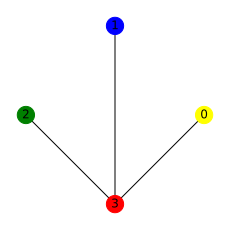

In [345]:
draw_subgraph(q1, node_lbl, node_clr_agg )

### BFS

In [346]:
q1.nodes

NodeView((0, 1, 2, 3))

In [347]:
node_lbl

{0: 19, 1: 5, 2: 14, 3: 7}

In [348]:
nx.set_node_attributes(q1, values=node_lbl, name='labels')


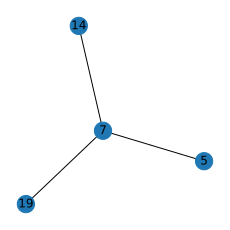

In [353]:
plt.figure(figsize=(3,3))
nx.draw(q1, with_labels=True, labels=node_lbl)

In [354]:
nx.relabel_nodes(q1, node_lbl, copy=False)

In [355]:
sorted(q1.nodes)

[5, 7, 14, 19]

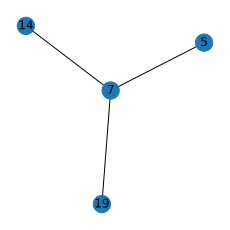

In [356]:
plt.figure(figsize=(3,3))
nx.draw(q1, with_labels=True)

In [358]:
#list(nx.bfs_edges(q1, source=4, depth_limit=1, ))

In [359]:
#list(nx.bfs_edges(q1, source=6, depth_limit=1))

In [360]:
#list(nx.bfs_edges(q1, source=13, depth_limit=1))

In [361]:
#bfslist = sorted(list(nx.bfs_tree(q1,13).edges()))

In [ ]:
####
- find the 


### May be a correction required in the logic
- nodes are in ascending order of labelling -- starting node is 5 in this case. 
- However, it'd be beneficial if a node ordering is based on its degree rather than ascending order 

In [362]:
n = 3
q_scidx = {}
scidx_q = {}
sc_idx = 0
visited = []

for node in sorted(q1.nodes):
    if node not in visited:
        scidx_q.setdefault(sc_idx, [])
        
        nodes_in_sc = set(list(sum(sorted(list(nx.bfs_tree(q1, source=node, depth_limit=1).edges())),())))
        print(f'nodes_in_sc: {nodes_in_sc}')
        
        for k in nodes_in_sc:
            ## required only if using to find cut wire position*****
            q_scidx.setdefault(k,[]) #q_scidx
            q_scidx[k].append(sc_idx) #q_scidx
            ## ********
            
            #print(f'visited: {visited}')
            if (k not in visited) and (len(scidx_q[sc_idx])<n) :
                scidx_q[sc_idx].append(k)
                visited.append(k)
        sc_idx += 1
    #print(f'q_scidx: {q_scidx}')


    
    

print(f'q_scidx: {q_scidx}')   
print(f'visited: {visited}')
print(f'scidx_q:{scidx_q}')   
cluster_labels 

qsc = collections.OrderedDict(sorted(scidx_q.items()))
qsc

nodes_in_sc: {5, 7}
nodes_in_sc: {14, 7}
nodes_in_sc: {19, 7}
q_scidx: {5: [0], 7: [0, 1, 2], 14: [1], 19: [2]}
visited: [5, 7, 14, 19]
scidx_q:{0: [5, 7], 1: [14], 2: [19]}


OrderedDict([(0, [5, 7]), (1, [14]), (2, [19])])

In [363]:
import collections
qsc = collections.OrderedDict(sorted(scidx_q.items()))

cluster_qubit ={}
bfs_cluster_labels = []

for key, val in qsc.items():
    print(key, val)
    for i in val:
        cluster_qubit.setdefault(i,[])
        cluster_qubit[i].append(key)
        bfs_cluster_labels.append(key)
        
print(cluster_qubit) 

bfs_cluster_labels

0 [5, 7]
1 [14]
2 [19]
{5: [0], 7: [0], 14: [1], 19: [2]}


[0, 0, 1, 2]

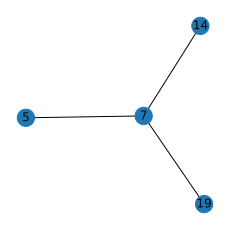

In [364]:
plt.figure(figsize=(3,3))
nx.draw(q1, with_labels=True)

In [365]:
kmeans_lbl
cluster_labels
node_lbl

{0: 19, 1: 5, 2: 14, 3: 7}

In [366]:
q1.nodes

NodeView((19, 5, 14, 7))

In [371]:
bfs_node_clr = dict(zip(list(sorted(q1.nodes)), bfs_cluster_labels))

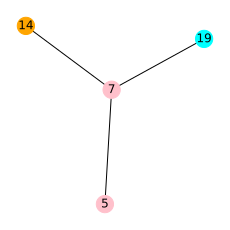

In [386]:
#draw_subgraph(q1, node_lbl, node_clr)
colors = ['pink', 'orange', 'cyan', 'yellow']
color_map = []
for node in q1:
    color_map.append(colors[bfs_node_clr[node]])
plt.figure(figsize=(3,3))
#pos = nx.circular_layout(q1)
nx.draw(q1, node_color=color_map, with_labels=True )
plt.show()

In [172]:
nx.bfs_tree(q1, source=0, depth_limit=1).edges()

OutEdgeView([(0, 9), (0, 6), (0, 4)])

In [186]:
sorted(list(nx.bfs_tree(q1, source=0).edges()))

[(0, 4), (0, 6), (0, 9), (2, 5), (6, 7), (7, 8), (9, 2)]

In [175]:
set(list(sum(sorted(list(nx.bfs_tree(q1, source=0, depth_limit=1).edges())),())))

{0, 4, 6, 9}

### Stoer Wagner Min Cut

In [120]:
cut_value, partition = nx.stoer_wagner(q1)

In [121]:
cut_value

1.0

In [122]:
partition

([6], [0, 1, 2, 3, 4, 5, 7])

In [123]:
from networkx.algorithms.flow import shortest_augmenting_path

In [124]:
nx.minimum_edge_cut(q1, flow_func=shortest_augmenting_path)

{(4, 5)}

In [127]:
for n in nx.all_node_cuts(q1):
    print(n)

{5}
{4}
{0}
{1}
